In [44]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly
import re

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [2]:
run = 46
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [3]:
qoisOutputed = ["comp(u,0)", "comp(u,1)", "comp(u,2)", "p", "T", "D", "S"]
probesV = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, file_type = "parquet")

In [4]:
start = 40000# 30000
stop = 120000
by = 1

processing data took 8 seconds
processing data took 14 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


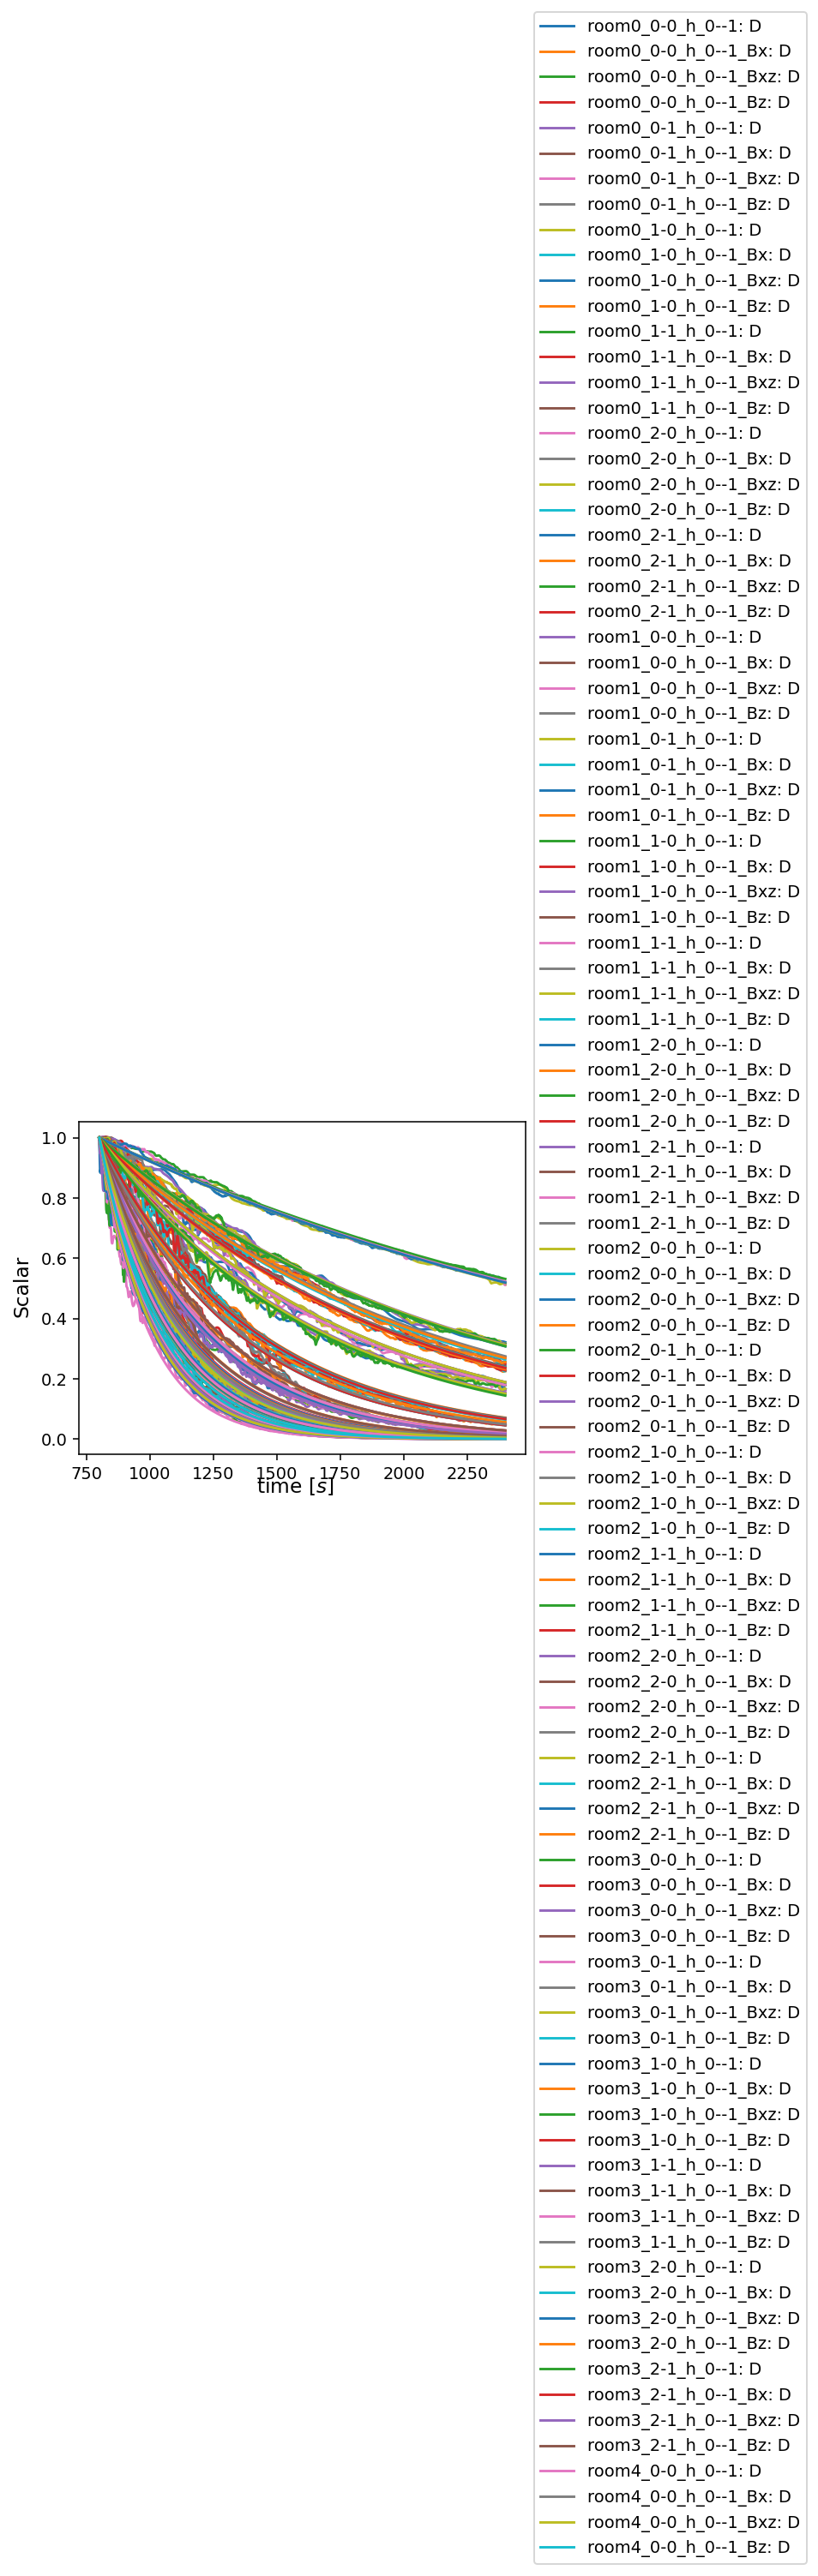

In [55]:
# Define the fitting function
def exponential_fit(data_dict, t_data = None):

    def func(series, time = t_data):
        time -= time.iloc[0]
        exp_decay = lambda x, a: np.exp(-x/a) #define theoretical exponential decay function
        popt, _ = sp.optimize.curve_fit(exp_decay, time, series, p0=1, bounds=(0, np.inf))
        return popt[0]

    if t_data is None:
        raise ValueError("Argument 'tdata' must be specified.")

    if isinstance(data_dict, dict):
        return {k: v.apply(func) for k, v in data_dict.items()}
    else:
        return data_dict.

steps = probesV.probe_steps[start:stop:by]
quants = ["D"]
times = probesV.probe_times[steps]
names = [name for name in  probesV.probe_names if "_h_0--1" in name][0:100]

(fig, ax) = probesV.time_plots(
    names = names, 
    steps = steps,
    quants = quants,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True,
    )

df = probesV.statistics(
    names = names, 
    steps = steps,
    quants = quants,
    parrallel=True,
    processing = [exponential_fit]
    )

exp_decay = lambda x, a: np.exp(-x/a)

for k, v in df.items():
    plt.plot(times, exp_decay(times - times.iloc[0], v.values[0]))

In [56]:
def sum_columns_by_room(df):
    # Dictionary to hold the grouped column names
    grouped_columns = {}

    # Loop over each column in the DataFrame
    for col in df.columns:
        # Extract the base name by removing the room number
        base_name = re.sub(r'room\d+', 'room', col)
        if base_name not in grouped_columns:
            grouped_columns[base_name] = []
        grouped_columns[base_name].append(col)
    
    # Sum the rows based on the grouped row names
    summed_df = pd.DataFrame()
    for base_name, cols in grouped_columns.items():
        summed_df[base_name] = df[cols].sum(axis=1)

    return summed_df
    
sum_columns_by_room(df).shape

(1, 24)

In [45]:
(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["D"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["S"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["T"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

KeyboardInterrupt: 